In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import urllib
from PIL import Image

In [4]:
PATH = 'data/tawkify/'
image_folder = f'{PATH}train/'
data_csv = PATH+'tw_dem_images.csv'
image_csv = PATH+'image_csv.csv'

In [5]:
sz=220

### Load Data

In [7]:
# df = pd.read_csv(PATH+'Photo_Income_Age_2.8.18.csv')

In [9]:
df = pd.read_csv(data_csv, dtype={'local_photo': 'object', 'image_type': 'object'})

In [ ]:
df.columns

In [ ]:
df['userID'].size

In [47]:
# df.drop('Unnamed: 0.1', axis=1, inplace=True)

In [93]:
df.head()

,userID,gender,attractedToGender,fromState,metro_name,User_Age,User_Photo,User_Income,local_photo,image_type
0,996294,female,male,CA,SF Peninsula,42.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,80000.0,data/tawkify/train/996294.jpg,corrupted
1,995253,female,male,CA,SF South Bay,45.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,0.0,data/tawkify/train/995253.jpg,corrupted
2,996305,male,female,CA,SF Peninsula,28.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,60000.0,data/tawkify/train/996305.jpg,corrupted
3,994861,female,male,CA,SF Peninsula,46.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,150000.0,data/tawkify/train/994861.jpg,corrupted
4,996334,male,female,CA,SF City,53.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,500000.0,data/tawkify/train/996334.jpg,corrupted


In [94]:
df.loc[df.userID == 922512].image_type.isna()

42648    True
Name: image_type, dtype: bool

### In case we need to delete bad images from the dataframe

In [72]:
df.loc[df.local_photo == 'data/tawkify/train/921661.jpg']

,Unnamed: 0,userID,gender,attractedToGender,fromState,metro_name,User_Age,User_Photo,User_Income,local_photo,image_type
42648,42648,922512,male,female,PA,Philadelphia,47.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,40000.0,data/tawkify/train/922512.jpg,None


In [33]:
df.at[42785, 'local_photo'] = 'corrupted'
df.at[42785, 'image_type'] = 'corrupted'

### Check for bad images instead

In [129]:
df.loc[df.userID == 937505]

,userID,gender,attractedToGender,fromState,metro_name,User_Age,User_Photo,User_Income,local_photo,image_type
34644,937505,male,female,TX,NaN,53.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,80000.0,data/tawkify/train/937505.jpg,gif


In [48]:
# If you want to replace nan files in local_photo
# df.local_photo.replace(np.nan, '', inplace=True)

In [52]:
# img_df = df.loc[(df.local_photo == 'data/tawkify/train/922512.jpg')]

In [136]:
img_df = df.loc[(df.local_photo != '') & ~df.local_photo.isna()]

In [137]:
import imghdr
for idx, row in img_df.iterrows():
    file = row.local_photo
    image_type = None
    try:
        image_type = imghdr.what(file)
    except Exception as e:
        image_type = 'corrupted'
    if image_type is None:
        image_type = 'corrupted'
    df.at[idx, 'image_type'] = image_type
    
    if image_type is not 'jpeg':
        try:
            os.rename(file, file.replace('train', 'corrupted'))
        except Exception as e:
            # file already removed
            pass

In [111]:
df.loc[df.userID == 922512]

,userID,gender,attractedToGender,fromState,metro_name,User_Age,User_Photo,User_Income,local_photo,image_type
42648,922512,male,female,PA,Philadelphia,47.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,40000.0,data/tawkify/train/922512.jpg,corrupted


In [55]:
img_df.head()

,Unnamed: 0,userID,gender,attractedToGender,fromState,metro_name,User_Age,User_Photo,User_Income,local_photo,image_type
0,0,996294,female,male,CA,SF Peninsula,42.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,80000.0,data/tawkify/train/996294.jpg,jpeg
1,1,995253,female,male,CA,SF South Bay,45.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,0.0,data/tawkify/train/995253.jpg,jpeg
2,2,996305,male,female,CA,SF Peninsula,28.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,60000.0,data/tawkify/train/996305.jpg,jpeg
3,3,994861,female,male,CA,SF Peninsula,46.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,150000.0,data/tawkify/train/994861.jpg,jpeg
4,4,996334,male,female,CA,SF City,53.0,https://s3-us-west-1.amazonaws.com/tawkifyfile...,500000.0,data/tawkify/train/996334.jpg,jpeg


In [14]:
file = 'data/tawkify/train/922512.jpg'
print(imghdr.what(file))

None


### Download images

In [ ]:
df.userID[0]

In [ ]:
df.shape

In [ ]:
# OLD SYNCHRONOUS WAY
# for index, row in tqdm(df.iterrows(), total=df.shape[0]):
#     user_id = row['userID']
#     image_url = row['User_Photo']
#     image_path = f'{image_folder}{user_id}.jpg'
#     if not os.path.exists(image_path):
#         try:
#             urllib.request.urlretrieve(image_url, image_path)
#             df['local_photo'][index] = image_path
#         except Exception as e:
# #             print('Could not download image for user:', user_id)
#             pass
#     else:
#         df['local_photo'][index] = image_path

In [ ]:
df.head()

In [112]:
df.to_csv(PATH+'tw_dem_images.csv')

In [ ]:
from concurrent.futures import ThreadPoolExecutor, wait, as_completed
from time import sleep

a = df.loc[(df.local_photo == '') | df.local_photo.isna()]

# TEST
a = a[:10000]
chunk_size = 1000
futures = []
# b = a.copy()

In [ ]:
def download_images(df):
    downloaded_images = {}
    failed_images = []
#     sleep(10)
#     return {}, []
    for index, row in df.iterrows():
        if df.index.name == 'userID':
            user_id = index
        else:
            user_id = row['userID']
        image_url = row['User_Photo']
        image_path = f'{image_folder}{user_id}.jpg'
        if os.path.exists(image_path):
            downloaded_images[user_id] = image_path
            continue
        try:
            urllib.request.urlretrieve(image_url, image_path)
            downloaded_images[user_id] = image_path
#                 df['local_photo'][index] = image_path
        except Exception as e:
#             print('Could not download image for user:', user_id)
            failed_images.append(user_id)
            continue
    return downloaded_images, failed_images
    
# urllib.request.urlretrieve('https://www.blog.google/static/blog/images/google-200x200.7714256da16f.png', f'{PATH}00000001.jpg')

In [ ]:
with ThreadPoolExecutor(5) as executor:
    for chunk in range(chunk_size, a.shape[0], chunk_size):
        idx_end = max(a.shape[0], chunk+chunk_size)
        futures.append(executor.submit(download_images, a[chunk:idx_end]))

    kwargs = {
        'total': len(futures),
        'unit': 'nap',
        'unit_scale': True,
        'leave': True,
        'disable': False
    }
    for x in tqdm(as_completed(futures), **kwargs):
        dl_imgs, failed = x.result()
        update_df = pd.DataFrame({'userID': list(dl_imgs.keys()), 'local_photo': list(dl_imgs.values())})
        if update_df.index.name != 'userID':
            update_df.set_index('userID', inplace=True)
        if df.index.name != 'userID':
            df.set_index('userID', inplace=True)
        df.update(update_df)
        
        failed_df = pd.DataFrame({'userID': list(failed), 'local_photo': 'corrupted', 'image_type': 'corrupted'})
        if failed_df.index.name != 'userID':
            failed_df.set_index('userID', inplace=True)
        df.update(failed_df)
    df.reset_index() # do we need this?

In [ ]:
# test
def wait_a(x):
    sleep(2)
    return x

futures = []
with ThreadPoolExecutor(5) as executor:
    
    for chunk in range(10):
        futures.append(executor.submit(wait_a, chunk))

    kwargs = {
        'total': len(futures),
        'unit': 'nap',
        'unit_scale': True,
        'leave': True,
        'disable': False
    }
    for x in tqdm(as_completed(futures), **kwargs):
        print('Finished:', x.result())

In [ ]:
b.head()

In [ ]:
a[chunk:idx_end]

### Read images

In [139]:
img_df = df.loc[(df.local_photo != '') 
                & (df.local_photo != 'corrupted') 
                & (df.image_type == 'jpeg') 
                & ~df.local_photo.isna()
               ]


In [ ]:
img_df = pd.read_csv(image_csv)

In [140]:
img_df.to_csv(image_csv)

In [ ]:
img_df.local_photo.iloc[np.random.randint(10)]

In [ ]:
plt.imshow(plt.imread(img_df.local_photo.iloc[np.random.randint(10)]))

In [ ]:
size_map = { idx:plt.imread(k.local_photo).shape for idx,k in img_df.iterrows()}

In [ ]:
size_map

In [ ]:
h, w, ch = list(zip(*size_map.values()))

In [ ]:
plt.hist(w)

In [ ]:
w = np.array(w)
plt.hist(w[w<600])

### Create training csv

In [7]:
model_csv = f'{PATH}current_model.csv'
# model_csv = f'{PATH}sample_model.csv'

In [142]:
temp_df = pd.DataFrame(data={'id': img_df.userID, 'gender': img_df.gender}, columns=['id', 'gender'])
temp_df.to_csv(model_csv, index=False)

In [143]:
temp_df.loc[temp_df.id == 937505]

,id,gender


### Architecture

In [64]:
# temp_df.sort_values('id').head()

In [65]:
# !rm -rf {PATH}tmp

In [8]:
temp_df = pd.read_csv(model_csv)

In [9]:
arch=resnet50

In [10]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
n = temp_df.shape[0]-1
val_idxs = get_cv_idxs(n)
# val_idxs = list(temp_df.iloc[val_idxs].id)
data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=model_csv, tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
# data = ImageClassifierData.from_csv(path=PATH, folder='train', csv_fname=image_csv, test_name='test', tfms=tfms, suffix='.jpg', val_idxs=val_idxs)
# new_data = data.resize(sz, 'tmp')

In [146]:
# fnames,y,classes = csv_source('train', model_csv, True, '.jpg', continuous=False)

In [147]:
data.trn_ds[0][0].shape

(3, 220, 220)

In [11]:
# learn = ConvLearner.pretrained(arch, data=data, precompute=True)
learn = ConvLearner.pretrained(arch, data=data, precompute=False)

In [ ]:
plt.imshow(plt.imread('data/tawkify/train/921661.jpg'))

In [149]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 80%|████████  | 365/454 [00:07<00:01, 51.92it/s, loss=2.05] 


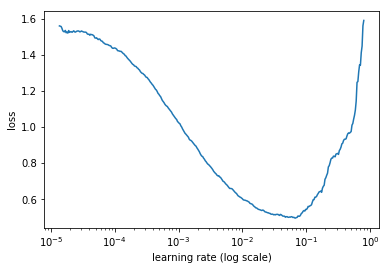

In [150]:
learn.sched.plot()

In [151]:
learn.fit(lrs=1e-2, n_cycle=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.343395   0.295831   0.884274  
    1      0.314937   0.278029   0.893001                    



[0.27802858, 0.8930007308198694]

In [11]:
learn.precompute=False

In [153]:
learn.fit(lrs=1e-2, n_cycle=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.307381   0.288171   0.890899  
    1      0.309722   0.276756   0.89195                     
    2      0.304614   0.269694   0.895239                    



[0.26969352, 0.8952394007590779]

In [12]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [155]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.236138   0.21168    0.922286  
    1      0.210451   0.196861   0.929231                    
    2      0.183167   0.191482   0.931743                    



[0.19148238, 0.9317434210526315]

In [156]:
learn.save('tw_gender_unfreeze1')

In [12]:
learn.load('tw_gender_unfreeze1')

In [ ]:
learn.fit(lrs=[1e-4,1e-3,1e-2], n_cycle=3, cycle_mult=2)

In [ ]:
log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy(log_preds,y), metrics.log_loss(y, probs)

In [ ]:
preds = np.argmax(log_preds, axis=1)
# np.array(preds==y).mean()
preds
# accuracy(log_preds,y)

### Test image

In [13]:
test_image_url = 'https://www.longines.com/uploads/ambassador/part1/chi-ling-lin-longines-ambassador-800x996.jpg'

In [42]:
# test_image_file = f'{PATH}test_images/test1.jpg'
test_image_file = f'{PATH}test_images/kenneth_s.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_2776.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_8274.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_3135.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_8819.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_9370.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_2793.jpg'
# test_image_file = f'{PATH}test_images/grandma_test1.jpg'
# test_image_file = f'{PATH}test_images/lzl_test1.jpg'
# test_image_file = f'{PATH}test_images/age_img/IMG_9625.jpg'

# test_image_file = f'{PATH}test_images/jackie_test1.jpg'

In [43]:
# urllib.request.urlretrieve(test_image_url, test_image_file)

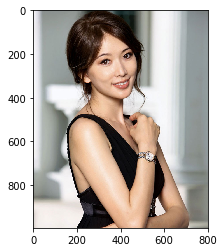

In [44]:
plt.imshow(plt.imread(test_image_file))

In [45]:
val_tfms = tfms[1]

In [46]:
_ = learn.model.eval()

In [47]:
# test_image = val_tfms(plt.imread(test_image_file))
test_image = val_tfms(open_image(test_image_file))
prediction = np.exp(learn.predict_array([test_image]))
class_prediction = data.classes[np.argmax(prediction)]
print('Prediction: ', class_prediction)

Prediction:  female
